In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

In [7]:
# function for printing classification metrics

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

def results_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Evaluate metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))  # Precision, Recall, F1-score

    # Compute and print ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

## Random forest model using data from all consultations and the child table

In [4]:
sampled_consultations_table = pd.read_parquet('Data/sampled_consultation_table_for_training.parquet')

In [5]:
sampled_consultations_table.columns

Index(['age_in_months', 'has_diarrhea', 'has_dehydration', 'has_dysentery',
       'has_anemia', 'has_pneumonia', 'has_malaria', 'has_measles',
       'has_malnutrition', 'has_danger_signs',
       ...
       'region_id_region_0d8e', 'region_id_region_5ae5',
       'region_id_region_77e8', 'region_id_region_7dcc',
       'region_id_region_b52b', 'region_id_region_b57b',
       'region_id_region_b6cf', 'region_id_region_c3a2',
       'region_id_region_df42', 'region_id_region_fa25'],
      dtype='object', length=107)

In [7]:
# need to remove all the information about vaccines from the training data

vaccine_info_columns = ['all_vaccines', 'number_missed_vaccines', 'missed_vaccines_category']

X_df = sampled_consultations_table.drop(columns=vaccine_info_columns)

y_df = sampled_consultations_table['all_vaccines']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=2)

Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.82      0.81     73553
        True       0.94      0.94      0.94    229785

    accuracy                           0.91    303338
   macro avg       0.87      0.88      0.87    303338
weighted avg       0.91      0.91      0.91    303338

ROC-AUC: 0.95


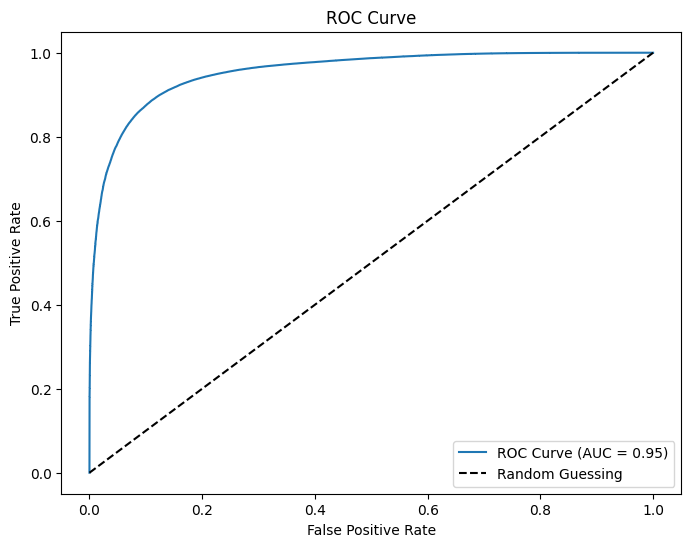

In [8]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier_merged_all_consultations = RandomForestClassifier(max_features='sqrt', class_weight={0: 3, 1: 1},n_estimators=100, min_samples_leaf=2, min_samples_split=5, max_depth=None, random_state=2)
RF_classifier_merged_all_consultations.fit(X_train, y_train)

results_metrics(RF_classifier_merged_all_consultations, X_test=X_test, y_test=y_test)


Feature Importance:


,Feature,Importance
29,first_last_visit_diff,1.267869e-01
0,age_in_months,1.258960e-01
31,visit_frequency,1.087896e-01
23,weight,8.648545e-02
26,vitamin_a,7.824490e-02
...,...,...
7,has_measles,1.647027e-05
13,has_suspicion_tuberculosis,4.733866e-06
1,has_diarrhea,3.990276e-06
12,has_suspicion_asthma,3.152552e-08


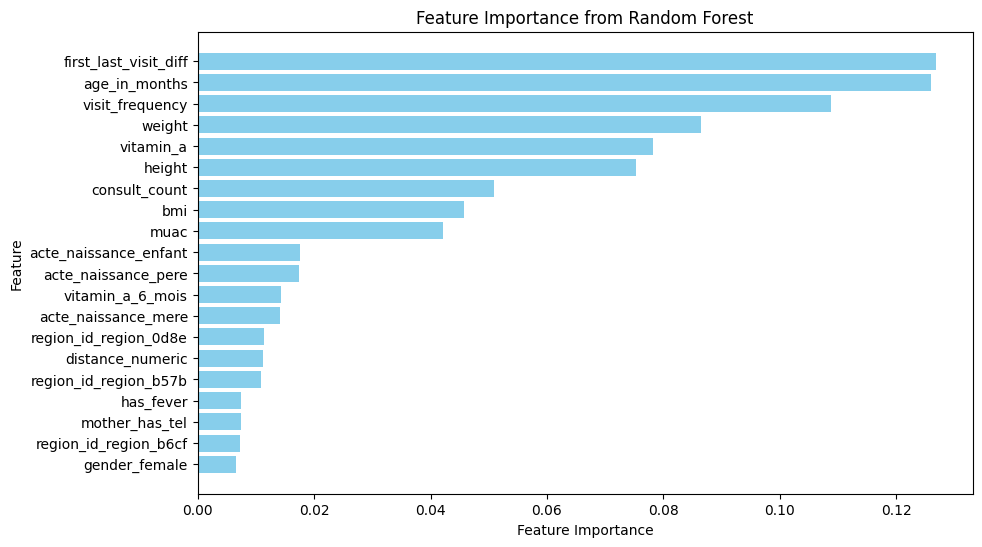

In [10]:
feature_importances = RF_classifier_merged_all_consultations.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_df.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
display(importance_df)

top_features = importance_df.head(20)


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance from Random Forest")
plt.show()

## Model using only consultation data

In [2]:
consultation_only_table_path = 'consultation_data_only_cleaned.parquet'
consultation_only_table = pd.read_parquet(consultation_only_table_path)

In [4]:
consultation_only_table.columns

Index(['age_in_months', 'has_diarrhea', 'has_dehydration', 'has_dysentery',
       'has_anemia', 'has_pneumonia', 'has_malaria', 'has_measles',
       'has_malnutrition', 'has_danger_signs', 'has_fever', 'has_hiv',
       'has_suspicion_asthma', 'has_suspicion_tuberculosis',
       'has_suspicion_asthma_tuberculosis',
       'has_at_least_one_severe_condition',
       'has_at_least_one_moderate_condition', 'distance_numeric',
       'district_id_district_0702', 'district_id_district_08f4',
       'district_id_district_0b94', 'district_id_district_0fe7',
       'district_id_district_14bd', 'district_id_district_1643',
       'district_id_district_164f', 'district_id_district_2978',
       'district_id_district_297a', 'district_id_district_29c2',
       'district_id_district_2ae1', 'district_id_district_2cd7',
       'district_id_district_32a1', 'district_id_district_3b38',
       'district_id_district_3b68', 'district_id_district_3f2a',
       'district_id_district_4212', 'district_id_d

In [5]:
# need to remove all the information about vaccines from the training data

vaccine_info_columns = ['all_vaccines', 'number_missed_vaccines', 'missed_vaccines_category']

X_df = consultation_only_table.drop(columns=vaccine_info_columns)

y_df = consultation_only_table['all_vaccines']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=2)

Classification Report:
              precision    recall  f1-score   support

       False       0.45      0.76      0.57     75331
        True       0.90      0.69      0.78    228007

    accuracy                           0.71    303338
   macro avg       0.67      0.73      0.67    303338
weighted avg       0.79      0.71      0.73    303338

ROC-AUC: 0.80


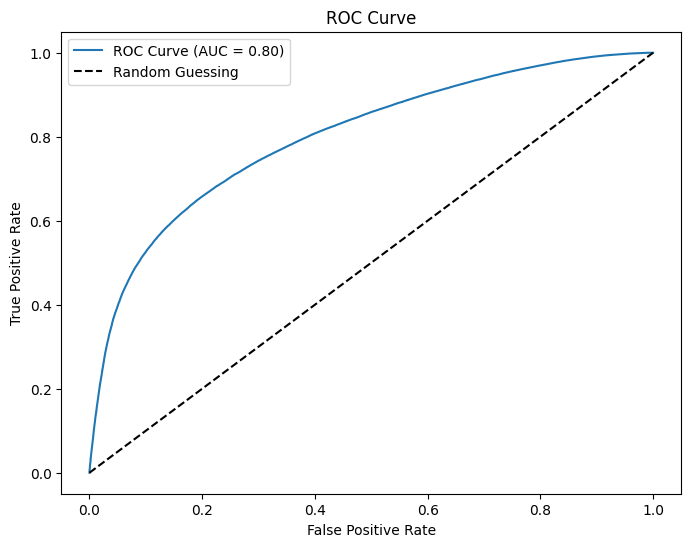

In [8]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier_consultations_only = RandomForestClassifier(max_features='sqrt', class_weight={0: 3, 1: 1},n_estimators=100, min_samples_leaf=2, min_samples_split=5, max_depth=None, random_state=2)
RF_classifier_consultations_only.fit(X_train, y_train)

results_metrics(RF_classifier_consultations_only, X_test=X_test, y_test=y_test)

In [9]:
child_table = pd.read_parquet('Data/child_table_cleaned.parquet')

In [10]:
child_table.columns

Index(['child_id', 'first_visit_date', 'last_visit_date', 'consult_count',
       'phc_id', 'district_id', 'region_id', 'mother_has_tel',
       'acte_naissance_enfant', 'acte_naissance_mere', 'acte_naissance_pere',
       'weight', 'height', 'muac', 'age_in_months', 'vitamin_a',
       'vitamin_a_3_mois', 'vitamin_a_6_mois', 'penta_1', 'penta_2', 'penta_3',
       'opv_0', 'opv_1', 'opv_2', 'opv_3', 'vpi', 'pneumo_1', 'pneumo_2',
       'pneumo_3', 'bcg', 'rotavirus_1', 'rotavirus_2', 'rotavirus_3',
       'measles_1', 'measles_2', 'yf', 'men_a', 'all_vaccines',
       'number_missed_vaccines', 'missed_vaccines_category',
       'first_last_visit_diff', 'visit_frequency', 'bmi', 'distance_numeric',
       'gender_female', 'gender_male'],
      dtype='object')

In [14]:
correlation_matrix = child_table[['all_vaccines','first_last_visit_diff','visit_frequency','consult_count','distance_numeric']].corr()

display(correlation_matrix)

,all_vaccines,first_last_visit_diff,visit_frequency,consult_count,distance_numeric
all_vaccines,1.000000,0.285886,0.249632,0.208633,-0.072613
first_last_visit_diff,0.285886,1.000000,0.856088,0.722509,-0.063070
visit_frequency,0.249632,0.856088,1.000000,0.403666,-0.043060
consult_count,0.208633,0.722509,0.403666,1.000000,-0.090935
distance_numeric,-0.072613,-0.063070,-0.043060,-0.090935,1.000000
